(2, 1000) (1000,)


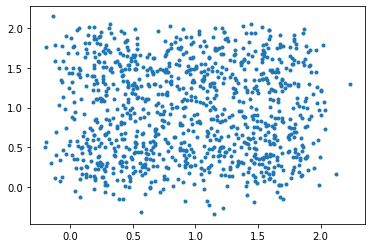

In [91]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import pickle

# load data
D = pickle.load(open("xorData.p", "rb"))
# print(D)

X = D.data
y = D.target

print(X.shape, y.shape)
# print(X1[:,0])

plt.figure()
plt.plot(X[0, :], X[1, :], '.')
# plt.plot(y1, y1, '.')
plt.show()


### Network training algorithm a)


In [92]:
def train(
    X=X,
    y=y,
    hidden_units=10,
    adaptation_step=1e-5,  # eta
    moment_term=0.9,  # alpha
    number_of_iterations=2000,  # iter
    activation_function=np.tanh,
):

    # Each row for each input
    # Each column for each hidden neuron
    # Start the hidden layer weights with low random values
    Wi = rd.randn(2, hidden_units) * .1
    # print(Wi)

    # Each row for each hidden neuron
    b = np.zeros((hidden_units, 1))
    # print(b)

    # Each row for the output of each hidden neuron
    # Start the output layer weights with low random values
    Wo = rd.randn(hidden_units, 1) * .1
    # print(Wo)

    # Bias for the output layer
    bo = 0

    # Initialize the derivatives
    dzWi = np.zeros(Wi.shape)
    dzb = np.zeros(b.shape)
    dzWo = np.zeros(Wo.shape)
    dzbo = 0

    Error = np.zeros(number_of_iterations)

    for n in range(number_of_iterations):
        # forward pass
        u = np.dot(Wi.T, X) + b
        v = activation_function(u)
        z = np.dot(Wo.T, v) + bo
        yh = activation_function(z)

        # error
        E = y-yh
        Error[n] = np.mean(E**2)

        # gradient
        dz = -2*E*(1-yh**2)
        dbo = np.sum(dz)
        dWo = np.dot(v, dz.T)
        du = (1-v**2)*np.dot(Wo, dz)
        db = np.sum(du, axis=1)
        dWi = np.dot(X, du.T)

        # adapt
        dzWi = moment_term * dzWi + dWi
        dzb = moment_term * dzb + db[:, np.newaxis]
        dzWo = moment_term * dzWo + dWo
        dzbo = moment_term * dzbo + dbo

        Wi = Wi - adaptation_step * dzWi
        b = b - adaptation_step * dzb
        Wo = Wo - adaptation_step * dzWo
        bo = bo - adaptation_step * dzbo

    plt.figure()
    plt.plot(Error)
    plt.grid(True)
    plt.show()


### Train network with 1 hidden unit b)


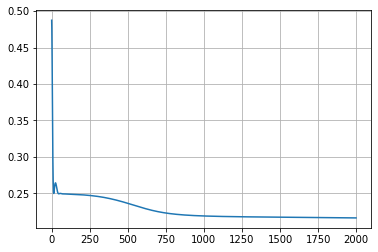

In [93]:
train(X, y, hidden_units=1)


### Train network with 10 hidden units c)


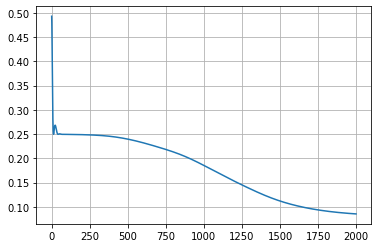

In [94]:
train(X, y, hidden_units=10)


### Train network with 50 hidden units d)


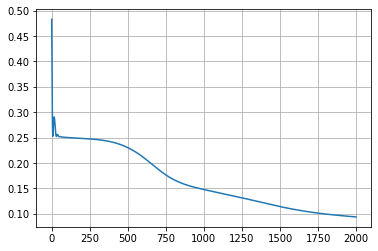

In [95]:
train(X, y, hidden_units=50)


In [96]:
plt.figure(figsize=(10, 5))
plt.plot(yh.squeeze(), '.')
plt.grid(True)


NameError: name 'yh' is not defined

<Figure size 720x360 with 0 Axes>

In [ ]:
plt.figure(figsize=(6, 6))
ye = (yh.squeeze() >= 0)*2-1
plt.plot(X[0, y == -1], X[1, y == -1], '.b')
plt.plot(X[0, y == 1], X[1, y == 1], '.r')
plt.plot(X[0, y != ye], X[1, y != ye], 'ok', alpha=.7)
print('Nº de erros:', np.sum(y != ye))


In [ ]:
from mpl_toolkits import mplot3d
gX, gY = np.meshgrid(np.linspace(-1, 2, 50), np.linspace(-1, 2, 50))
X2 = np.vstack((gX.ravel(), gY.ravel()))
u = np.dot(Wi.T, X2)+b
v = np.tanh(u)
z = np.dot(Wo.T, v)
yh = np.tanh(z+bo)
Yh = np.reshape(yh, (50, 50))

fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection='3d')
# ax.contour3D(gX,gY,Yh,50,cmap='binary')
ax.plot_wireframe(gX, gY, Yh)
